In [8]:
# Importing the dependencies
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the data into the tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory("data", batch_size=32, image_size=(256, 256), shuffle=True)
class_names = dataset.class_names


print("Class names are : ",class_names)
print(f"Our data is in total : {len(dataset)} batches")

Found 4710 files belonging to 2 classes.
Class names are :  ['Apple___Cedar_apple_rust', 'Apple___healthy']
Our data is in total : 148 batches


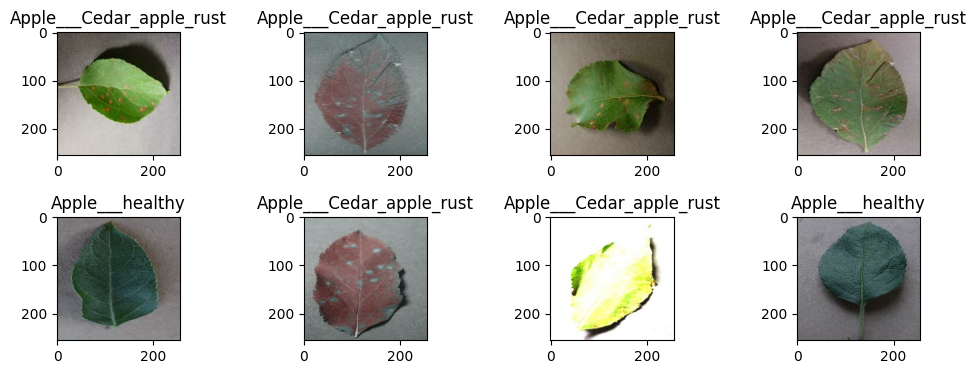

In [3]:
# Let's visualize one of the image from the batch
fig, ax = plt.subplots(2,4,figsize=(12, 4))

# Printing 8 images from the first batch of the dataset
for img_batch, label_batch in dataset.take(1):

    for i in range(2):
        for j in range(4):
            ax[i, j].set_title(class_names[label_batch[i * 4 + j]])
            ax[i, j].imshow(img_batch[i * 4 + j].numpy().astype("uint8"))

# Adjusting the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [4]:
# training size, validation size, shuffle size
training_size = 0.8
validation_size = 0.1
shuffle_size = 10000

# Function for creating test, train and validation data batches
def train_test_val_batches(dataset, training_size, validation_size, shuffle_size):

    # Shuffling the dataset
    dataset = dataset.shuffle(shuffle_size, seed=12)

    # Creating batches for train, test, and validation
    train_dataset = dataset.take(int(len(dataset) * training_size))
    test_dataset = dataset.skip(int(len(dataset) * training_size))
    validation_dataset = test_dataset.take(int(len(test_dataset) * validation_size))

    # Cache, Shuffle, and Prefetch the Datasets
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset, validation_dataset


# Calling the function
train_ds, test_ds, val_ds = train_test_val_batches(dataset, training_size, validation_size, shuffle_size)

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [5]:
# Rescaling and resizing layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
input_shape = (32, 256, 256, 3)
n_classes = 2

model = models.Sequential([

    # First we will resize and rescale our images
    resize_and_rescale,

    # We will create new data for making our model robust
    data_augmentation,

    # Let's now add conovlutional and pooling layers
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the feature map for feeding in vanilla artificial neural network
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
# Let's get the entire summary of our model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [13]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
118/118 [==============================] - 110s 689ms/step - loss: 0.2742 - accuracy: 0.8872 - val_loss: 0.1946 - val_accuracy: 0.9479
Epoch 2/50
118/118 [==============================] - 41s 349ms/step - loss: 0.1473 - accuracy: 0.9480 - val_loss: 0.1786 - val_accuracy: 0.9479
Epoch 3/50
118/118 [==============================] - 36s 304ms/step - loss: 0.0756 - accuracy: 0.9744 - val_loss: 0.2695 - val_accuracy: 0.9271
Epoch 4/50
118/118 [==============================] - 35s 301ms/step - loss: 0.1145 - accuracy: 0.9637 - val_loss: 0.3389 - val_accuracy: 0.9062
Epoch 5/50
118/118 [==============================] - 36s 304ms/step - loss: 0.0817 - accuracy: 0.9720 - val_loss: 0.1071 - val_accuracy: 0.9583
Epoch 6/50
118/118 [==============================] - 35s 294ms/step - loss: 0.0568 - accuracy: 0.9829 - val_loss: 0.0885 - val_accuracy: 0.9583
Epoch 7/50
118/118 [==============================] - 34s 289ms/step - loss: 0.0423 - accuracy: 0.9856 - val_loss: 0.5271 - val_a

KeyboardInterrupt: 